In [1]:
import datapackage
import pandas as pd
from io import StringIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from quarantine import quarantine

In [2]:
def getdata(data_url = 'https://datahub.io/core/covid-19/datapackage.json', resourcename='countries-aggregated_csv'):
    """
    Get data from the web
    data_url : string with url of the data from datahub
    resourcename : resource to use
    """

    # to load Data Package into storage
    package = datapackage.Package(data_url)
    resources = package.resources

    for resource in resources:
        if resource.name == resourcename:
            url=resource.descriptor['path']
            print('Importing',url)
            s=requests.get(url).text
            data = pd.read_csv(StringIO(s))
    return data

In [3]:
def readdata(filenamebase='data/covid_data_',date=datetime.date.today().isoformat()):
    """
    Reads the data from CSV file
    
    Parameters:
    
    filenamebase : basename of the saved file. Full filename is filenamebase + date + '.csv'
    date : date of the data. Default: today's date 
    
    Output:
    
    pd.DataFrame
    
    """
    filename='%s%s.csv' % (filenamebase,date)
    with open(filename,'r') as file:
        data=pd.read_csv(file)
    return data

In [4]:
def savedata(dataframe,filenamebase='data/covid_data_',date=datetime.date.today().isoformat()):
    """
    Save the dataframe as CSV file
    
    Parameters
    ----------

    dataframe : pd.DataFrame to save. Default 'covid_data_'
    filenamebase : basename of the saved file. Full filename is filenamebase + date + '.csv'
    date : date of the data. Default: today's date
    """
    filename='%s%s.csv' % (filenamebase,date)
    with open(filename,'w') as file:
        dataframe.to_csv(file,index=False)

In [5]:
defaultcountrylist=('Colombia', 'Italy', 'US')
d=getdata()
def builddatalist(indicator = 'Confirmed', minindicator=1, countrylist=defaultcountrylist, fulldata=d):
    """
    Build a list of data for selected countries 
    
    Parameters
    ----------
    indicator : indicator to shift the time series
    minindicator : value to start the time series. 
        Day 0 corresponds to the day when indicator >= minindicator
    countrylist : list of countries to build the datalist
    fulldata : raw data for all countries
    """
    datalist={}
    for country in countrylist:
        dat=fulldata[fulldata['Country']==country]
        dat=dat[dat[indicator]>=minindicator]
        dat['Day']=np.arange(len(dat))
        datalist[country]=dat
    return datalist

Importing https://pkgstore.datahub.io/core/covid-19/countries-aggregated_csv/data/1d1988619760aa27906ca3ef022db9e7/countries-aggregated_csv.csv


In [7]:
savedata(d)

In [49]:
def plotdata(indicator = 'Confirmed', minindicator=1, dayrange = {'min': 0, 'max' : -1}, 
             logscale=True, countrylist=defaultcountrylist, fulldata=d):
    """
    Plots data for selected countries and indicator
    
    Parameters
    ----------
    indicator : indicator to shift the time series
    minindicator : value to start the time series. 
        Day 0 corresponds to the day when indicator >= minindicator
    dayrange : dict with min, max range to plot. max=-1 is plot all
    logscale: plot in logscale (True) or linear (False)
    countrylist : list of countries to build the datalist
    fulldata : raw data for all countries
    """
    datalist=builddatalist(indicator, minindicator, countrylist, d)
    yax=indicator
    fig, ax = plt.subplots(figsize=(12,6))
    for country in countrylist:
        color = next(ax._get_lines.prop_cycler)['color']
        df=datalist[country]
        if df.empty:
            continue
        df=df[dayrange['min'] <= df['Day']]
        if dayrange['max']!=-1 :
            df=df[df['Day']<=dayrange['max']]
        # Get day 0 date
        dayzero_df=df[df['Day']==0]
        dayzero_date=dayzero_df.at[dayzero_df.index[-1],'Date']
        if not isinstance(logscale, bool):
            logscale=True
        df.plot(x='Day',y=yax,logy=logscale,label='%s day 0: %s' % (country,dayzero_date),ax=ax, color=color)
        # get quarantine day info
        try:
            quarantine_date=quarantine[country]
        except KeyError:
            print('%s not in quarantine'%(country))
        else:
            quarantine_day_df=df[df['Date']==quarantine_date]
           #     print(quarantine_day_df)
            try:
                quarantine_day=quarantine_day_df.at[quarantine_day_df.index[-1],'Day']
           #    print(quarantine_day)
            except IndexError:
                # Quarantine date is out of bounds
                print('%s quarantine date %s out of bounds. Day zero is %s' %(country,quarantine_date, dayzero_date))
            else:
                ax.axvline(x=quarantine_day, color=color,
                           label='%s quarantine on day %d (%s)' % (country,quarantine_day,quarantine_date))
    ax.set_ylabel(yax)
    ax.set_xlabel('Days from first day when "'+indicator+'" >='+str(minindicator))
    if logscale:
        labellog = ' (log scale)'
    else:
        labellog = ''   
    ax.set_title(indicator+' covid-19' + labellog)
    ax.grid()
    ax.legend()
    return fig

US not in quarantine


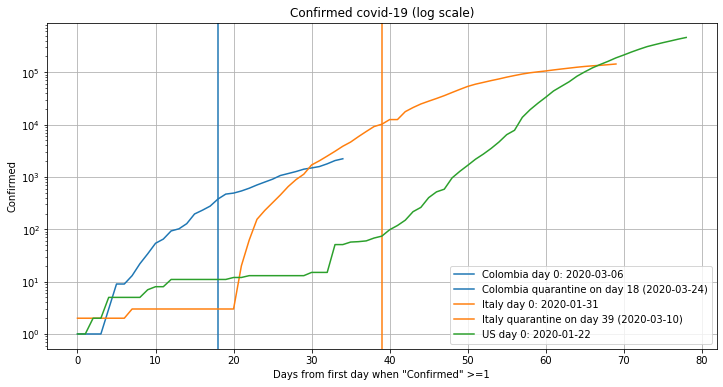

In [9]:
plotdata();

US not in quarantine


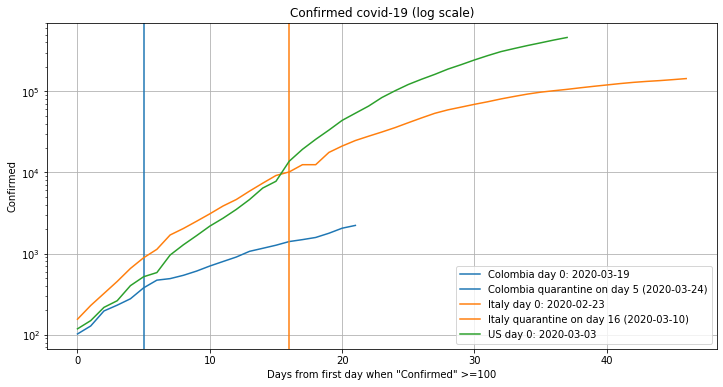

In [10]:
figc100=plotdata(minindicator=100)

Colombia quarantine date 2020-03-24 out of bounds. Day zero is 2020-03-29
US not in quarantine


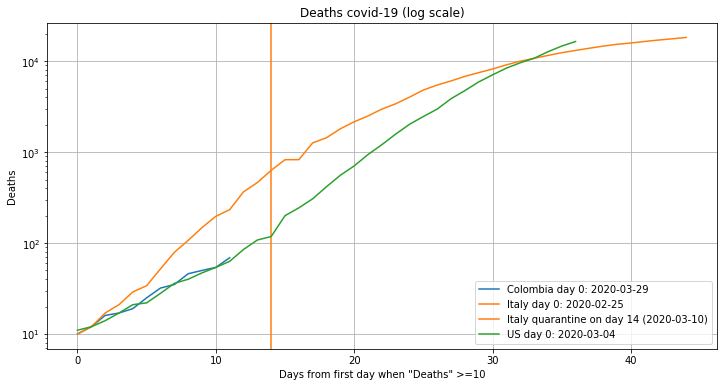

In [11]:
figd10=plotdata(indicator='Deaths', minindicator=10)

US not in quarantine


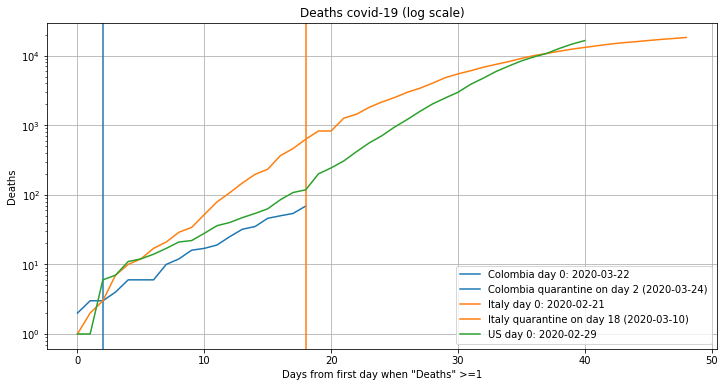

In [12]:
plotdata(indicator='Deaths', minindicator=1);

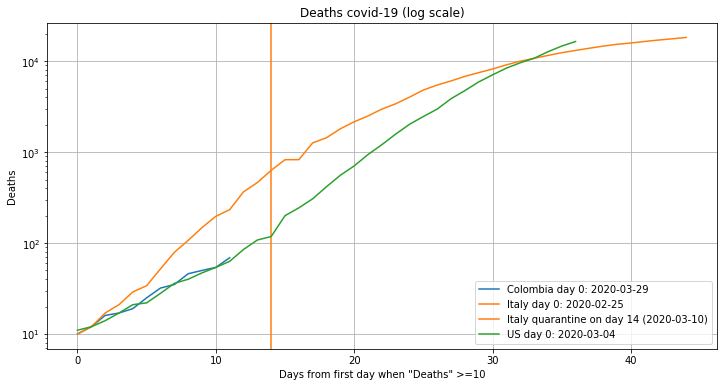

In [13]:
figd10

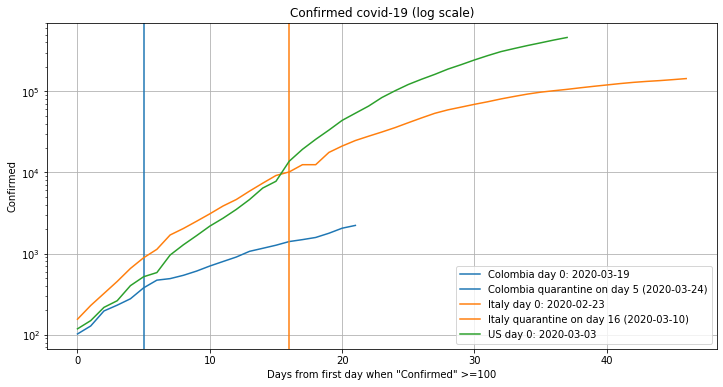

In [14]:
figc100

US not in quarantine


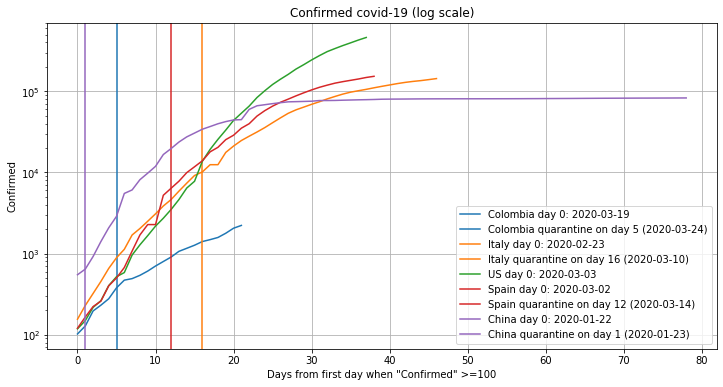

In [15]:
plotdata(countrylist=defaultcountrylist+('Spain','China'),minindicator=100);

Colombia quarantine date 2020-03-24 out of bounds. Day zero is 2020-03-27
US not in quarantine


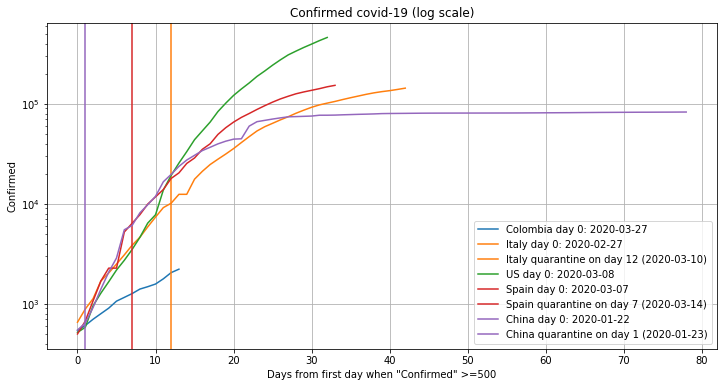

In [16]:
plotdata(countrylist=defaultcountrylist+('Spain','China'),minindicator=500);

Colombia quarantine date 2020-03-24 out of bounds. Day zero is 2020-03-29
US not in quarantine


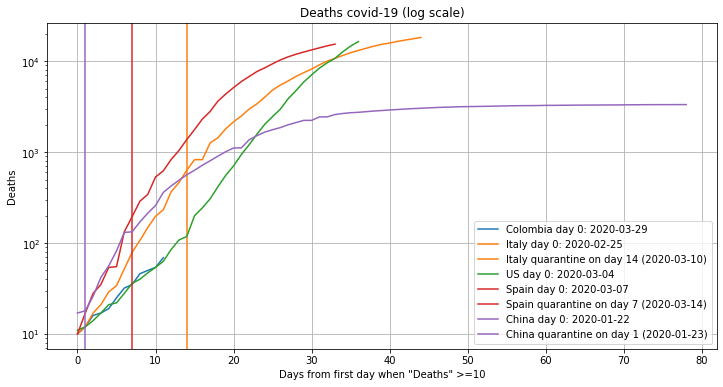

In [17]:
plotdata(countrylist=defaultcountrylist+('Spain','China'),indicator='Deaths',minindicator=10);

In [7]:
d[d['Country']=='China']

,Date,Country,Confirmed,Recovered,Deaths
36,2020-01-22,China,548,28,17
221,2020-01-23,China,643,30,18
406,2020-01-24,China,920,36,26
591,2020-01-25,China,1406,39,42
776,2020-01-26,China,2075,49,56
...,...,...,...,...,...
13911,2020-04-06,China,82665,77310,3335
14096,2020-04-07,China,82718,77410,3335
14281,2020-04-08,China,82809,77567,3337
14466,2020-04-09,China,82883,77679,3339


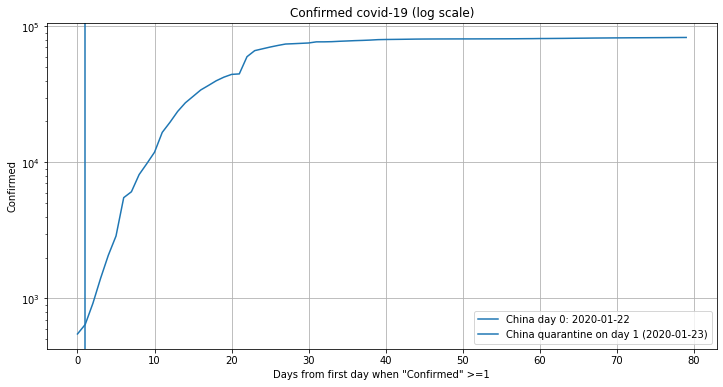

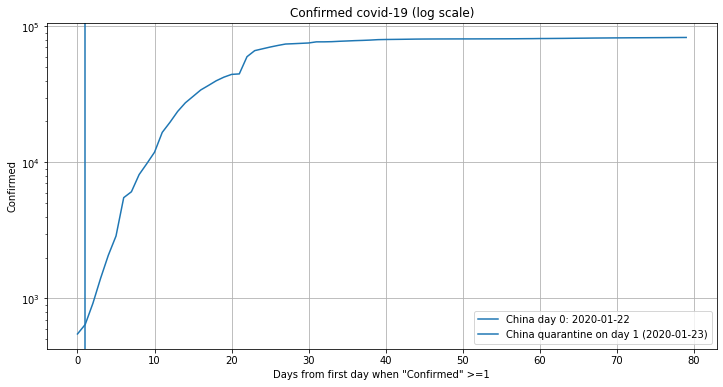

In [11]:
plotdata(countrylist=('China',))

In [10]:
builddatalist(countrylist=('China',))

{'China':              Date Country  Confirmed  Recovered  Deaths  Day
 36     2020-01-22   China        548         28      17    0
 221    2020-01-23   China        643         30      18    1
 406    2020-01-24   China        920         36      26    2
 591    2020-01-25   China       1406         39      42    3
 776    2020-01-26   China       2075         49      56    4
 ...           ...     ...        ...        ...     ...  ...
 13911  2020-04-06   China      82665      77310    3335   75
 14096  2020-04-07   China      82718      77410    3335   76
 14281  2020-04-08   China      82809      77567    3337   77
 14466  2020-04-09   China      82883      77679    3339   78
 14651  2020-04-10   China      82941      77791    3340   79
 
 [80 rows x 6 columns]}

In [12]:
import requests

In [13]:
url = 'https://lab.isaaclin.cn/nCoV/api/all?latest=0'
r = requests.request('GET', url)

data = r.json()
df = pd.DataFrame.from_records(data['results'])
df

KeyError: 'results'

In [14]:
data

{'detail': 'Not Found'}

In [15]:
r

<Response [404]>

In [16]:
url = 'https://lab.isaaclin.cn/nCoV/api/area?latest=1'
r = requests.request('GET', url)
data = r.json()
df = pd.DataFrame.from_records(data['results'])

In [17]:
df

,locationId,continentName,continentEnglishName,countryName,countryEnglishName,provinceName,provinceEnglishName,provinceShortName,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,deadCount,comment,cities,updateTime
0,965003,欧洲,Europe,波黑,Bosnia and Herzegovina,波黑,Bosnia and Herzegovina,波黑,725,901,0,139,37,,None,1586667752967
1,971002,北美洲,North America,美国,United States of America,美国,United States of America,美国,477252,529951,0,32091,20608,,None,1586667752967
2,954002,亚洲,Asia,吉尔吉斯斯坦,None,吉尔吉斯斯坦,None,吉尔吉斯斯坦,301,339,0,33,5,,None,1586667752967
3,983001,非洲,Africa,喀麦隆,Cameroon,喀麦隆,Cameroon,喀麦隆,726,836,0,98,12,,None,1586667752967
4,952010,亚洲,Asia,泰国,Thailand,泰国,Thailand,泰国,1295,2551,0,1218,38,,None,1586667752967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0,欧洲,Europe,大不列颠及北爱尔兰联合王国,United Kingdom of Great Britain and Ireland,大不列颠及北爱尔兰联合王国,United Kingdom of Great Britain and Ireland,大不列颠及北爱尔兰联合王国,12,20,0,8,0,,None,1582960272252
249,0,欧洲,Europe,英国（含北爱尔兰）,United Kingdom,英国（含北爱尔兰）,United Kingdom,英国（含北爱尔兰）,12,20,0,8,0,,None,1582952928516
250,0,欧洲,Europe,北爱尔兰,Northern Ireland,北爱尔兰,Northern Ireland,北爱尔兰,1,1,0,0,0,,None,1582864428698
251,540000,亚洲,Asia,中国,China,西藏自治区,Xizang,西藏,0,1,0,1,0,,"[{'cityName': '拉萨', 'currentConfirmedCount': 0...",1582456742938


In [18]:
data

{'results': [{'locationId': 965003,
   'continentName': '欧洲',
   'continentEnglishName': 'Europe',
   'countryName': '波黑',
   'countryEnglishName': 'Bosnia and Herzegovina',
   'provinceName': '波黑',
   'provinceEnglishName': 'Bosnia and Herzegovina',
   'provinceShortName': '波黑',
   'currentConfirmedCount': 725,
   'confirmedCount': 901,
   'suspectedCount': 0,
   'curedCount': 139,
   'deadCount': 37,
   'comment': '',
   'cities': None,
   'updateTime': 1586667752967},
  {'locationId': 971002,
   'continentName': '北美洲',
   'continentEnglishName': 'North America',
   'countryName': '美国',
   'countryEnglishName': 'United States of America',
   'provinceName': '美国',
   'provinceEnglishName': 'United States of America',
   'provinceShortName': '美国',
   'currentConfirmedCount': 477252,
   'confirmedCount': 529951,
   'suspectedCount': 0,
   'curedCount': 32091,
   'deadCount': 20608,
   'comment': '',
   'cities': None,
   'updateTime': 1586667752967},
  {'locationId': 954002,
   'contine

In [19]:
newdatadf=pd.read_csv('https://raw.githubusercontent.com/BlankerL/DXY-COVID-19-Data/master/csv/DXYArea.csv')

In [20]:
newdatadf

,continentName,continentEnglishName,countryName,countryEnglishName,provinceName,provinceEnglishName,province_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,updateTime,cityName,cityEnglishName,city_zipCode,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount
0,欧洲,Europe,爱尔兰,Ireland,爱尔兰,Ireland,961003,8089,0.0,62,320,2020-04-12 11:49:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,亚洲,Asia,印度,India,印度,India,953003,8356,0.0,716,273,2020-04-12 11:49:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,欧洲,Europe,丹麦,Denmark,丹麦,Denmark,962001,5996,0.0,894,260,2020-04-12 11:49:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,亚洲,Asia,菲律宾,Philippines,菲律宾,Philippines,952008,4428,0.0,157,247,2020-04-12 11:49:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,亚洲,Asia,黎巴嫩,Lebanon,黎巴嫩,Lebanon,955012,619,0.0,76,20,2020-04-12 11:49:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132609,亚洲,Asia,中国,China,辽宁省,Liaoning,210000,0,1.0,0,0,2020-01-22 03:28:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132610,亚洲,Asia,中国,China,台湾,Taiwan,710000,1,0.0,0,0,2020-01-22 03:28:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132611,亚洲,Asia,中国,Hongkong,香港,Hongkong,810000,0,117.0,0,0,2020-01-22 03:28:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132612,亚洲,Asia,中国,China,黑龙江省,Heilongjiang,230000,0,1.0,0,0,2020-01-22 03:28:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
newdatadf[-100:-1]

,continentName,continentEnglishName,countryName,countryEnglishName,provinceName,provinceEnglishName,province_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,updateTime,cityName,cityEnglishName,city_zipCode,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount
132514,亚洲,Asia,中国,China,云南省,Yunnan,530000,2,0.0,0,0,2020-01-24 03:25:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132515,亚洲,Asia,中国,China,江西省,Jiangxi,360000,7,0.0,0,0,2020-01-24 00:35:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132516,亚洲,Asia,中国,China,河北省,Hebei,130000,1,0.0,0,1,2020-01-24 00:34:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132517,亚洲,Asia,中国,China,云南省,Yunnan,530000,2,0.0,0,0,2020-01-24 00:30:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132518,亚洲,Asia,中国,Hongkong,香港,Hongkong,810000,2,65.0,0,0,2020-01-23 23:07:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132608,亚洲,Asia,中国,China,重庆市,Chongqing,500000,5,0.0,0,0,2020-01-22 03:28:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132609,亚洲,Asia,中国,China,辽宁省,Liaoning,210000,0,1.0,0,0,2020-01-22 03:28:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132610,亚洲,Asia,中国,China,台湾,Taiwan,710000,1,0.0,0,0,2020-01-22 03:28:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132611,亚洲,Asia,中国,Hongkong,香港,Hongkong,810000,0,117.0,0,0,2020-01-22 03:28:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
d[d['Country']=='China']

,Date,Country,Confirmed,Recovered,Deaths
36,2020-01-22,China,548,28,17
221,2020-01-23,China,643,30,18
406,2020-01-24,China,920,36,26
591,2020-01-25,China,1406,39,42
776,2020-01-26,China,2075,49,56
...,...,...,...,...,...
13911,2020-04-06,China,82665,77310,3335
14096,2020-04-07,China,82718,77410,3335
14281,2020-04-08,China,82809,77567,3337
14466,2020-04-09,China,82883,77679,3339


In [27]:
overall_df=pd.read_csv('https://raw.githubusercontent.com/BlankerL/DXY-COVID-19-Data/master/csv/DXYOverall.csv')

In [28]:
overall_df

,_id,infectSource,passWay,dailyPic,dailyPics,summary,countRemark,currentConfirmedCount,confirmedCount,suspectedCount,...,quanguoTrendChart,hbFeiHbTrendChart,foreignTrendChart,importantForeignTrendChart,foreignTrendChartGlobal,importantForeignTrendChartGlobal,foreignStatistics,globalStatistics,globalOtherTrendChartData,updateTime
0,5e92a0e95ab90d734b1603a9,该字段已替换为说明2,该字段已替换为说明3,https://img1.dxycdn.com/2020/0211/763/33959988...,['https://img1.dxycdn.com/2020/0211/763/339599...,NaN,NaN,2113.0,83482,1280,...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0324...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0326...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,"{'currentConfirmedCount': 1229322, 'confirmedC...","{'currentConfirmedCount': 1231435, 'confirmedC...",https://file1.dxycdn.com/2020/0412/650/3407319...,2020-04-12 13:02:32
1,5e929c675ab90d734b1602d8,该字段已替换为说明2,该字段已替换为说明3,https://img1.dxycdn.com/2020/0211/763/33959988...,['https://img1.dxycdn.com/2020/0211/763/339599...,NaN,NaN,2113.0,83482,1280,...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0324...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0326...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,"{'currentConfirmedCount': 1229220, 'confirmedC...","{'currentConfirmedCount': 1231333, 'confirmedC...",https://file1.dxycdn.com/2020/0412/650/3407319...,2020-04-12 12:43:19
2,5e9298d35ab90d734b1602d2,该字段已替换为说明2,该字段已替换为说明3,https://img1.dxycdn.com/2020/0211/763/33959988...,['https://img1.dxycdn.com/2020/0211/763/339599...,NaN,NaN,2113.0,83482,1280,...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0324...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0326...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,"{'currentConfirmedCount': 1229273, 'confirmedC...","{'currentConfirmedCount': 1231386, 'confirmedC...",https://file1.dxycdn.com/2020/0412/650/3407319...,2020-04-12 12:28:03
3,5e928fcf5ab90d734b1602cc,该字段已替换为说明2,该字段已替换为说明3,https://img1.dxycdn.com/2020/0211/763/33959988...,['https://img1.dxycdn.com/2020/0211/763/339599...,NaN,NaN,2113.0,83482,1280,...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0324...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0326...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,"{'currentConfirmedCount': 1229967, 'confirmedC...","{'currentConfirmedCount': 1232080, 'confirmedC...",https://file1.dxycdn.com/2020/0412/650/3407319...,2020-04-12 11:49:35
4,5e9283b15ab90d734b1602b6,该字段已替换为说明2,该字段已替换为说明3,https://img1.dxycdn.com/2020/0211/763/33959988...,['https://img1.dxycdn.com/2020/0211/763/339599...,NaN,NaN,2113.0,83482,1280,...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0324...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0326...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0320...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0319...,"{'currentConfirmedCount': 1229234, 'confirmedC...","{'currentConfirmedCount': 1231347, 'confirmedC...",https://file1.dxycdn.com/2020/0412/650/3407319...,2020-04-12 10:57:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036,5e2ada10f58597d4d01ddb15,野生动物，可能中华菊头蝠,未完全掌握，存在人传人、医务人员感染、一定范围社区传播,https://img1.dxycdn.com/2020/0124/981/33927191...,NaN,NaN,全国确诊894例，疑似1076例，治愈35例，死亡26例,NaN,894,1076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-24 19:50:40
4037,5e2ad14bf58597d4d01ddb0a,野生动物，可能中华菊头蝠,未完全掌握，存在人传人、医务人员感染、一定范围社区传播,https://img1.d

US not in quarantine


IndexError: index -1 is out of bounds for axis 0 with size 0

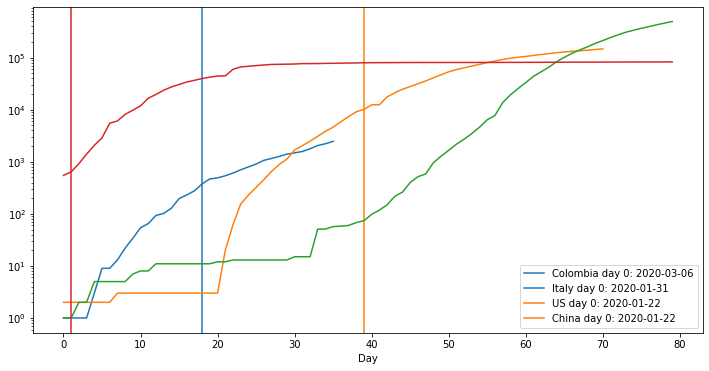

In [29]:
plotdata(countrylist=defaultcountrylist+('China','Korea'))

In [30]:
builddatalist(countrylist=('China','toto'))

{'China':              Date Country  Confirmed  Recovered  Deaths  Day
 36     2020-01-22   China        548         28      17    0
 221    2020-01-23   China        643         30      18    1
 406    2020-01-24   China        920         36      26    2
 591    2020-01-25   China       1406         39      42    3
 776    2020-01-26   China       2075         49      56    4
 ...           ...     ...        ...        ...     ...  ...
 13911  2020-04-06   China      82665      77310    3335   75
 14096  2020-04-07   China      82718      77410    3335   76
 14281  2020-04-08   China      82809      77567    3337   77
 14466  2020-04-09   China      82883      77679    3339   78
 14651  2020-04-10   China      82941      77791    3340   79
 
 [80 rows x 6 columns],
 'toto': Empty DataFrame
 Columns: [Date, Country, Confirmed, Recovered, Deaths, Day]
 Index: []}

IndexError: index -1 is out of bounds for axis 0 with size 0

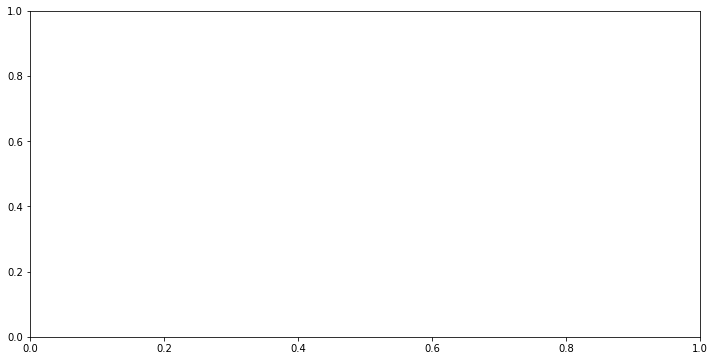

In [31]:
plotdata(countrylist=('toto',))

No handles with labels found to put in legend.


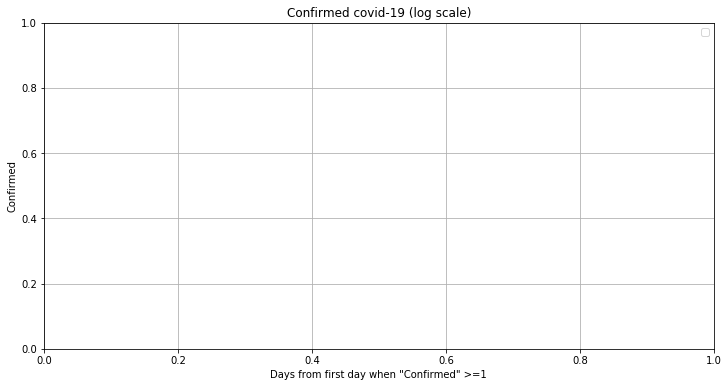

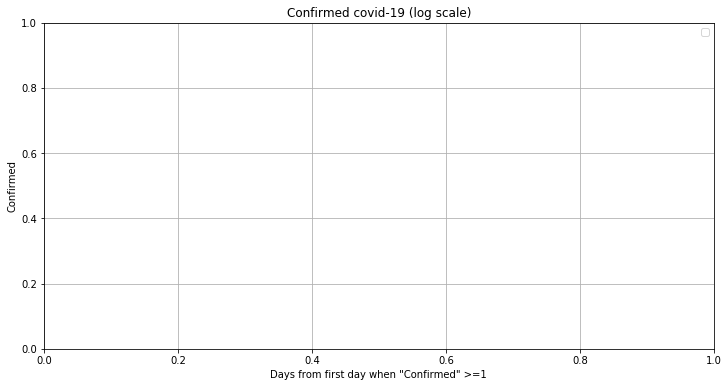

In [33]:
plotdata(countrylist=('toto',))

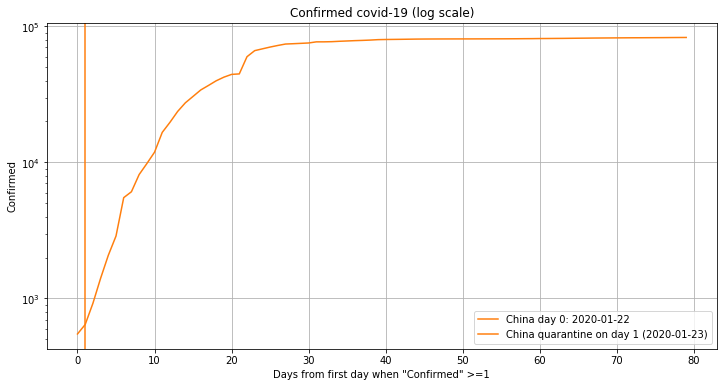

In [34]:
plotdata(countrylist=('toto','China'));

US not in quarantine
Korea, South not in quarantine


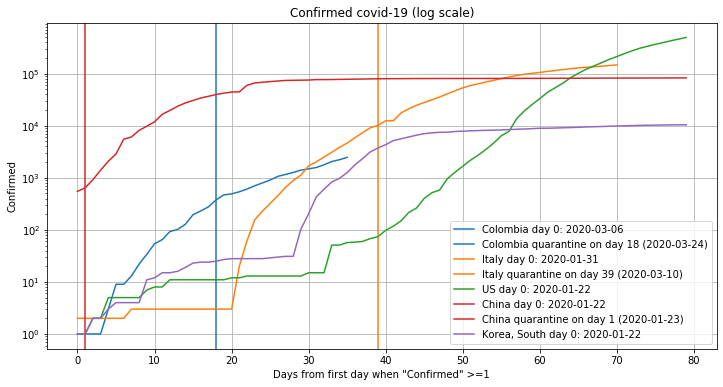

In [36]:
plotdata(countrylist=defaultcountrylist+('China','Korea, South'));

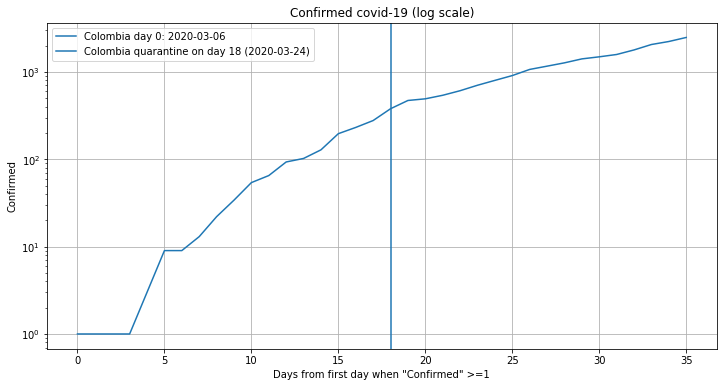

In [37]:
plotdata(countrylist=('Colombia',));

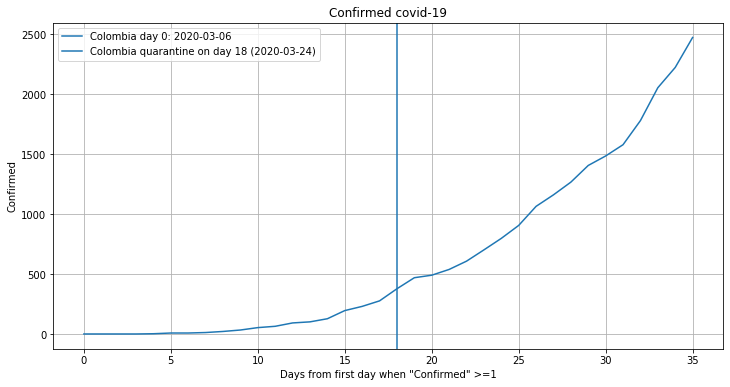

In [38]:
plotdata(countrylist=('Colombia',),logscale=False);

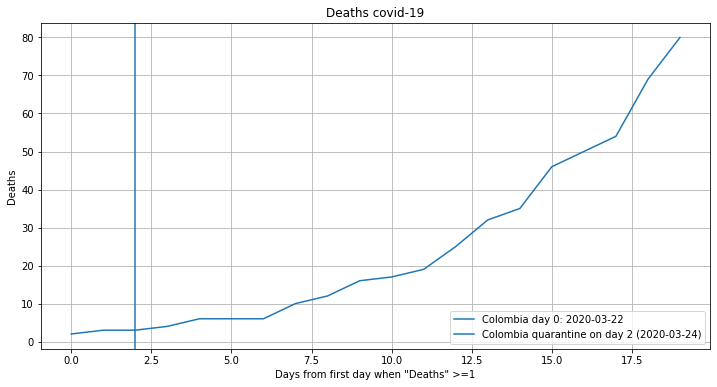

In [39]:
plotdata(countrylist=('Colombia',),logscale=False, indicator='Deaths');

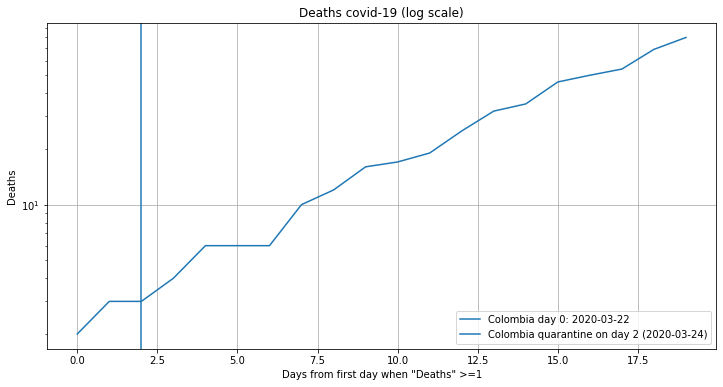

In [40]:
plotdata(countrylist=('Colombia',),logscale=True, indicator='Deaths');

US not in quarantine


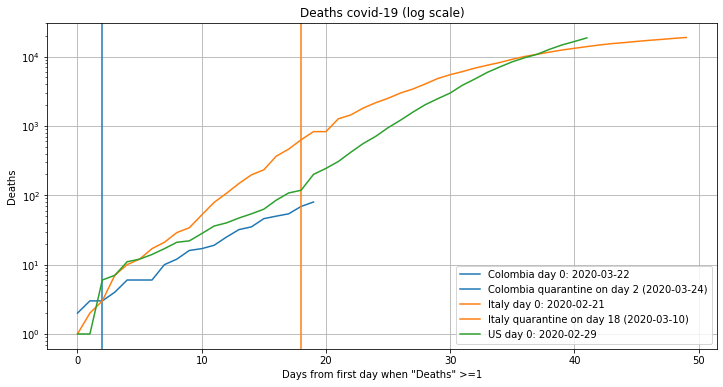

In [41]:
plotdata(indicator='Deaths');

US not in quarantine


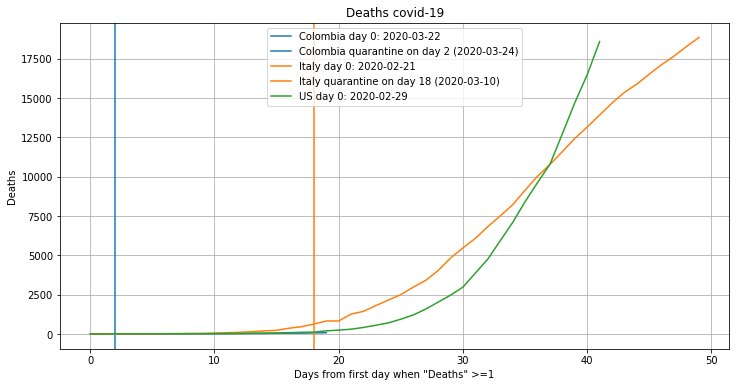

In [43]:
plotdata(indicator='Deaths',logscale=False);

US not in quarantine


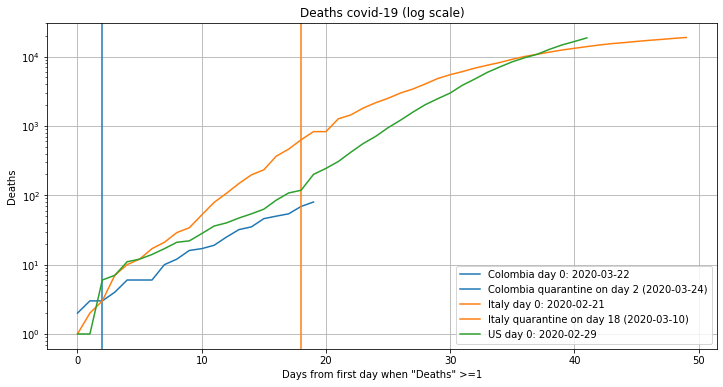

In [50]:
plotdata(indicator='Deaths',logscale='False');

US not in quarantine


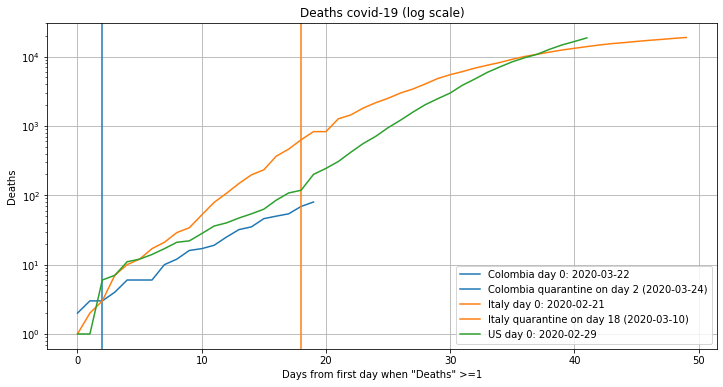

In [51]:
plotdata(indicator='Deaths',logscale='True');

US not in quarantine


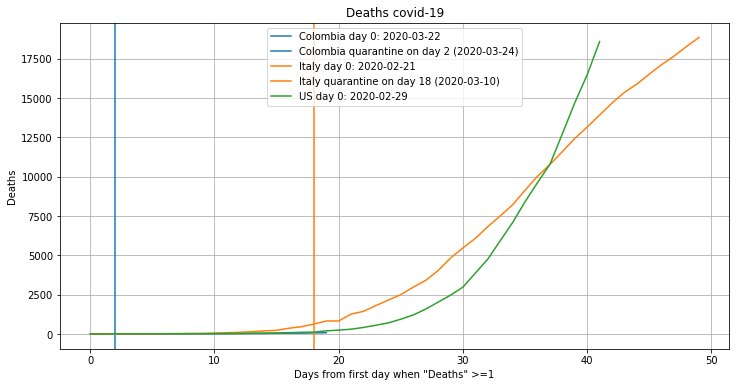

In [54]:
plotdata(indicator='Deaths',logscale=False);

In [55]:
help(plotdata)

Help on function plotdata in module __main__:

plotdata(indicator='Confirmed', minindicator=1, dayrange={'min': 0, 'max': -1}, logscale=True, countrylist=('Colombia', 'Italy', 'US'), fulldata=             Date             Country  Confirmed  Recovered  Deaths
0      2020-01-22         Afghanistan          0          0       0
1      2020-01-22             Albania          0          0       0
2      2020-01-22             Algeria          0          0       0
3      2020-01-22             Andorra          0          0       0
4      2020-01-22              Angola          0          0       0
...           ...                 ...        ...        ...     ...
14795  2020-04-10  West Bank and Gaza        267         45       2
14796  2020-04-10      Western Sahara          4          0       0
14797  2020-04-10               Yemen          1          0       0
14798  2020-04-10              Zambia         40         25       2
14799  2020-04-10            Zimbabwe         13          0 